<i><h2 style="font-family:serif;font-size:300%; text-align:center;color:#004d80"> Tarea 3 Machine Learning<br>  Métodos No-Lineales</h2></i>



#### Observación: Este notebook está pensado para ser leido en formato html, por favor descargar la versión en dicho formato for maximum sexyness.
Ignacio Loayza C. 201273604-8<br>
Camilo Perez P.

In [292]:
%matplotlib inline
# Imports

#Neural Networks
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

#numerico
import numpy as np
import pandas as pd

#Machine Learning
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Metricas
from sklearn.metrics import f1_score


#Stats models
import statsmodels.api as sm

#Regresor lineal
import sklearn.linear_model as lm

#Graficos
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style("darkgrid")
import graphviz

# Warnings
import warnings
warnings.filterwarnings('ignore')

#Shallow copy
import copy

#preprocesamiento
from sklearn import preprocessing

#HTML incrustation
from IPython.display import display, HTML

display(HTML("""
<style>
p {
    color: black;
    font-family: Serif;
    font-size: 1.23em;
}

</style>

"""))


In [294]:
#Funciones
############### DO CIRCLES #####################
def do_circles(n = 2000, noisy_n = 0.05):
    generator = check_random_state(10)
    linspace = np.linspace(0, 2*np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)
    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    X = np.vstack((np.append(outer_circ_x, inner_circ_x),
                  np.append(outer_circ_y, inner_circ_y))).T
    y = np.hstack([np.zeros(n // 2, dtype = np.intp),
                  np.ones(n // 2, dtype = np.intp)])
    X += generator.normal(scale = noisy_n, size = X.shape)
    
    X_train , X_test, y_train,y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
    return X_train, y_train, X_test, y_test

############### VISUALIZE BORDER #####################
def visualize_border(x, y, title = "", model = None):
        fig = plt.figure(figsize=(12,6))
        plt.scatter(x[:,0], x[:,1], s = 50, c=y, cmap=plt.cm.winter)
        h = .02 #step size?
        x_min, x_max = x[:, 0].min() - 1, x[:, 0].max()+1
        y_min, y_max = x[:, 1].min() - 1, x[:, 1].max()+1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        
        if model is not None:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, cmap = plt.cm.Paired)
        
        plt.title(title)
        plt.show()
############### PLOT CLASSIFIER #####################
def plot_classifier(clf, X_train, Y_train, X_test, Y_test, model_type):
    f,axis = plt.subplots(1,1,sharex='col',sharey='row',figsize=(12,8))
    axis.scatter(X_train[:,0], X_train[:,1], s=30, c=Y_train, zorder = 10, cmap = 'cool')
    axis.scatter(X_test[:,0], X_test[:,1], s = 20, c = Y_test, zorder = 10, cmap= 'Greys')
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    
    if model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    
    else:raise ValueError('model type not supported')
    
    Z = Z.reshape(XX.shape)
    Zplot = Z >= 0.5
    axis.pcolormesh(XX, YY, Zplot, cmap = 'YlGn')
    axis.contour(XX, YY, Z, alpha = 1, colors = ['k','k','k'], linestyles = ['--','-','--'], levels = [-2, 0, 2])
    plt.show()

############### CROSS-VALIDATION ERROR #####################
# usaremos esto nuevamente para la regularizacion, como se utiliza bastante seguido la metodologia de obtener
#crossvalidation y regresion, lo implemente en una sola funcion apra llamarla en solo una linea
def cv_error(x_train, y_train,method , k = 10, **kargs):
    Xm = copy.copy(x_train.as_matrix())
    ym = copy.copy(y_train.as_matrix())
    kf = KFold(n_splits = k)

    
    #Decision tree classif
    if(method == 'TreeClassifier'):
        f1_score_vector = []
        accuracy_vector = []
        for train, test in kf.split(Xm, ym):
            if kargs['max_depth'] != None:
                tree_clf = DecisionTreeClassifier(max_depth=kargs['max_depth'], criterion = 'entropy') 
            else:
                tree_clf = DecisionTreeClassifier(criterion = 'entropy')
            
            tree_clf.fit(Xm[train],ym[train])

            #print("[fold {0}], score: {1:.5f}".format(k, tree_clf.score(Xm[test], ym[test])))
            accuracy_vector.append(1.0 - tree_clf.score(Xm[train],ym[train]))
            f1_score_vector.append(f1_score(ym[test], tree_clf.predict(Xm[test])))
        return np.mean(f1_score_vector), np.mean(accuracy_vector), tree_clf

    #RandomForest Classif
    if(method == 'RandomForest'):
        f1_score_vector = []
        accuracy_vector = []
        for train, test in kf.split(Xm, ym):
            if kargs['max_depth'] != None:
                rforest_clf = RandomForestClassifier(n_estimators = kargs['n_estimators'], max_depth=kargs['max_depth'], criterion = 'entropy', n_jobs=1) 
            else:
                rforest_clf = RandomForestClassifier(n_estimators = kargs['n_estimators'], criterion = 'entropy', n_jobs=1)
            
            rforest_clf.fit(Xm[train],ym[train])

            #print("[fold {0}], score: {1:.5f}".format(k, tree_clf.score(Xm[test], ym[test])))
            accuracy_vector.append(1.0 - rforest_clf.score(Xm[train],ym[train]))
            f1_score_vector.append(f1_score(ym[test], rforest_clf.predict(Xm[test])))
        return np.mean(f1_score_vector), np.mean(accuracy_vector), rforest_clf

    #AdaBoost Classif
    if(method == 'AdaBoost'):
        f1_score_vector = []
        accuracy_vector = []
        for train, test in kf.split(Xm, ym):
            if kargs['max_depth'] != None:
                adaboost_clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=kargs['max_depth'], 
                                                                        criterion = 'entropy'), 
                                                  n_estimators = kargs['n_estimators']) 
            else:
                adaboost_clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 10, 
                                                                        criterion = 'entropy'), 
                                                  n_estimators = kargs['n_estimators'])
            
            adaboost_clf.fit(Xm[train],ym[train])

            #print("[fold {0}], score: {1:.5f}".format(k, tree_clf.score(Xm[test], ym[test])))
            accuracy_vector.append(1.0 - adaboost_clf.score(Xm[train],ym[train]))
            f1_score_vector.append(f1_score(ym[test], adaboost_clf.predict(Xm[test])))
        return np.mean(f1_score_vector), np.mean(accuracy_vector), adaboost_clf

    #KNN Classif
    if(method == 'KNN'):
        f1_score_vector = []
        accuracy_vector = []
        for train, test in kf.split(Xm, ym):
            knn_clf = KNeighborsClassifier(n_neighbors = kargs['n_neighbors']) 
            knn_clf.fit(Xm[train],ym[train])

            #print("[fold {0}], score: {1:.5f}".format(k, tree_clf.score(Xm[test], ym[test])))
            accuracy_vector.append(knn_clf.score(Xm[train],ym[train]))
            f1_score_vector.append(f1_score(ym[test], knn_clf.predict(Xm[test])))
        return np.mean(f1_score_vector), np.mean(accuracy_vector), knn_clf
    
        

############### PLOT CV ERROR #####################
def plot_cv_error(x_train, y_train, meth, k = 10, **kargs):
    max_score = 0
    ################ DecisionTree ##########################
    if(meth == 'TreeClassifier'):
        best_tree = DecisionTreeClassifier()
        cv_err_vector = []
        if(kargs['max_depth'] == None):
            print("Hiperparámetro max_depth faltante")
            return None
        for depth in range(1,kargs['max_depth']+1, 1):
            f1_score, mean_accuracy, tree = cv_error(x_train, y_train, k = k, method = 'TreeClassifier', max_depth = depth)
            cv_err_vector.append((depth, f1_score, mean_accuracy))
            if(f1_score > max_score):
                best_tree = copy.copy(tree)
                max_score = copy.copy(f1_score)
        cv_err_df = pd.DataFrame(cv_err_vector, columns = ['depth', 'f1 score', 'training error'])

        fig = plt.figure(figsize=(12,6))
        plt.plot(cv_err_df['depth'], cv_err_df['f1 score'], 'o-')
        plt.plot(cv_err_df['depth'], cv_err_df['training error'])
        plt.xticks(range(1,kargs['max_depth']+1, 1))
        plt.xlabel("Profundidad del árbol")
        plt.ylabel("F1 Score")
        plt.title('Decision Tree: F1 Score en función de la profundidad del árbol')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        return best_tree, max_score

    ################ RandomForest ##########################
    if(meth == 'RandomForest'):
        best_forest = RandomForestClassifier()
        cv_err_vector = []
        
        if(kargs['max_estimators'] == None):
            max_estimators = 10
        else:
            max_estimators = kargs['max_estimators']

        if(kargs['max_depth'] == None):
            depth = 10
        else:
            depth = kargs['max_depth']

        for estimators in range(1,max_estimators+1, 1):
            f1_score, mean_accuracy, rforest = cv_error(x_train, y_train, k = k, method = 'RandomForest', 
                                                        max_depth = depth, n_estimators = estimators)
            cv_err_vector.append((estimators, f1_score, mean_accuracy))
            if(f1_score > max_score):
                best_tree = copy.copy(rforest)
                max_score = copy.copy(f1_score)
        cv_err_df = pd.DataFrame(cv_err_vector, columns = ['estimators', 'f1 score', 'training error'])

        fig = plt.figure(figsize=(12,6))
        plt.plot(cv_err_df['estimators'], cv_err_df['f1 score'], 'o-')
        plt.plot(cv_err_df['estimators'], cv_err_df['training error'])
        plt.xticks(range(1,max_estimators+1, 1))
        plt.xlabel("Número de estimadores")
        plt.ylabel("F1 Score")
        plt.title('RandomForest: F1 Score en función del número de estimadores')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        return best_tree, max_score
    
    ################ AdaBoost ##########################
    if(meth == 'AdaBoost'):
        best_forest = AdaBoostClassifier()
        cv_err_vector = []
        
        if(kargs['max_estimators'] == None):
            max_estimators = 10
        else:
            max_estimators = kargs['max_estimators']

        if(kargs['max_depth'] == None):
            depth = 10
        else:
            depth = kargs['max_depth']

        for estimators in range(1,max_estimators+1, 1):
            f1_score, mean_accuracy, ada_clf = cv_error(x_train, y_train, k = k, method = 'AdaBoost', 
                                                        max_depth = depth, n_estimators = estimators)
            cv_err_vector.append((estimators, f1_score, mean_accuracy))
            if(f1_score > max_score):
                best_ada = copy.copy(ada_clf)
                max_score = copy.copy(f1_score)
        cv_err_df = pd.DataFrame(cv_err_vector, columns = ['estimators', 'f1 score', 'training error'])

        fig = plt.figure(figsize=(12,6))
        plt.plot(cv_err_df['estimators'], cv_err_df['f1 score'], 'o-')
        plt.plot(cv_err_df['estimators'], cv_err_df['training error'])
        plt.xticks(range(1,max_estimators+1, 1))
        plt.xlabel("Número de estimadores")
        plt.ylabel("F1 Score")
        plt.title('AdaBoost: F1 Score en función del número de estimadores')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        return best_ada, max_score
    
    ################ KNN ##########################
    if(meth == 'KNN'):
        best_knn = KNeighborsClassifier()
        cv_err_vector = []
        
        if(kargs['max_neighbors'] == None):
            max_neighbors = 10
        else:
            max_neighbors = kargs['max_neighbors']

        for neighbors in range(1,max_neighbors+1, 1):
            f1_score, mean_accuracy, knn_clf = cv_error(x_train, y_train, k = k, method = 'KNN', n_neighbors = neighbors)
            cv_err_vector.append((neighbors, f1_score, mean_accuracy))
            if(f1_score > max_score):
                best_knn = copy.copy(knn_clf)
                max_score = copy.copy(f1_score)
        cv_err_df = pd.DataFrame(cv_err_vector, columns = ['number of neighbors', 'f1 score', 'training error'])

        fig = plt.figure(figsize=(12,6))
        plt.plot(cv_err_df['number of neighbors'], cv_err_df['f1 score'], 'o-')
        plt.plot(cv_err_df['number of neighbors'], cv_err_df['training error'])
        plt.xticks(range(1,max_neighbors+1, 1))
        plt.xlabel("Número de Vecinos")
        plt.ylabel("F1 Score")
        plt.title('KNN: F1 Score en función del número de vecinos')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        return best_knn, max_score


############### PLOT TREE #####################
def plot_tree(tree_clf): 
    dot_data = tree.export_graphviz(tree_clf, out_file = None)
    graph = graphviz.Graph(dot_data)
    graph.graph_attr.update(size = "7.75,10.25")
    graph.render("Wave")
    dot_data = tree.export_graphviz(tree_clf, out_file=None,   
                         filled=True, rounded=True,  
                         special_characters=True,)  
    graph = graphviz.Source(dot_data)


    return graph

In [131]:
?plt.plot

<i><h2 style="font-family:serif;font-size:260%; text-align:center;color:#004d80"> Small Circle inside Large Circle</h2></i>

In [109]:
X_train, y_train, X_test, y_test = do_circles(noisy_n=0.05)

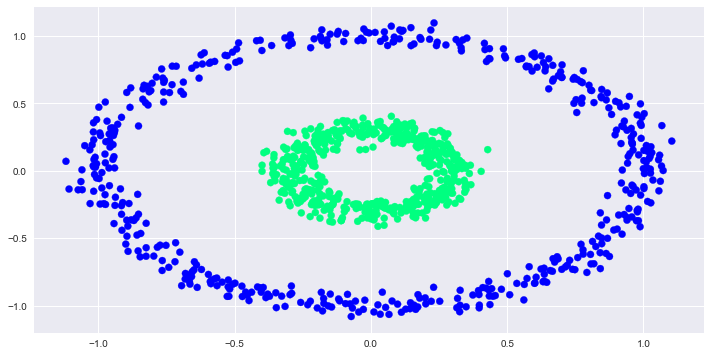

In [110]:
visualize_border(X_train,y_train)

<p style="text-align:center;font-size:95%"><b>Figura 1:</b> Conjunto de datos inicial, formado a partir de dos circulos con ruido de 0.05.</p>

Se tiene el conjunto de datos mostrado en la figura anterior, nuestro objetivo inicial será encontrar una frontera de decisión que clasifique correctamente las dos clases de datos, para esto, comenzaremos utilizando una aproximación basada en redes neuronales artificiales.

<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> I) Clasificador de perceptrón único</h3></i>

Comenzaremos el estudio de los clasificadores generando uno basado en una sola neurona, demostraremos empíricamente que este clasificador se ve imposibilitado de encontrar una frontera de clasificación correcta, exploraremos diferentes funciones de activación para diversificar el problema.

In [118]:
n_h = 1
model = Sequential();
model.add(Dense(1, input_dim = X_train.shape[1], kernel_initializer = 'uniform', activation = 'relu'));
model.add(Dense(n_h, init = 'uniform', activation = 'sigmoid'));
model.compile(optimizer = SGD(lr=1), loss = 'binary_crossentropy', metrics = ['accuracy']);
model.fit(X_train, y_train, epochs = 50, batch_size = 100, verbose = 1);
scores = model.evaluate(X_test, y_test);
test_acc = scores[1];

Epoch 1/50
1000/1000 [==============================] - 1s 654us/step - loss: 0.6941 - acc: 0.5150
Epoch 2/50
1000/1000 [==============================] - 0s 39us/step - loss: 0.6930 - acc: 0.4970
Epoch 3/50
1000/1000 [==============================] - 0s 36us/step - loss: 0.6901 - acc: 0.5330
Epoch 4/50
1000/1000 [==============================] - 0s 44us/step - loss: 0.6875 - acc: 0.5340
Epoch 5/50
1000/1000 [==============================] - 0s 41us/step - loss: 0.6734 - acc: 0.6680
Epoch 6/50
1000/1000 [==============================] - 0s 38us/step - loss: 0.6515 - acc: 0.5970
Epoch 7/50
1000/1000 [==============================] - 0s 31us/step - loss: 0.6246 - acc: 0.6590
Epoch 8/50
1000/1000 [==============================] - 0s 38us/step - loss: 0.6018 - acc: 0.6650
Epoch 9/50
1000/1000 [==============================] - 0s 38us/step - loss: 0.5859 - acc: 0.6720
Epoch 10/50
1000/1000 [==============================] - 0s 38us/step - loss: 0.5769 - acc: 0.6760
Epoch 11/50
1000/1

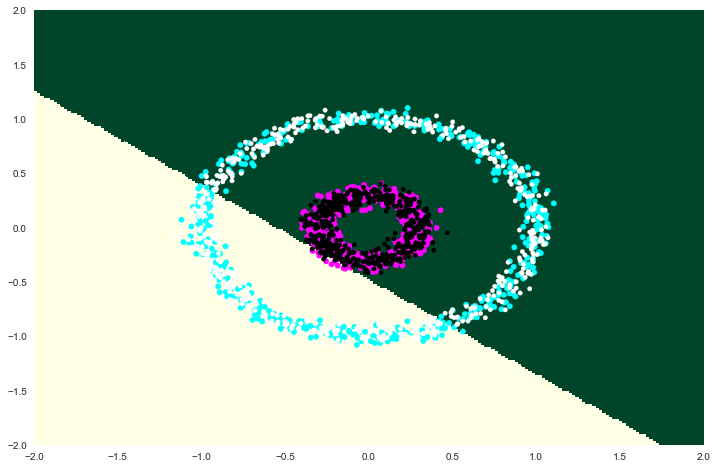

In [119]:
plot_classifier(model, X_train, y_train, X_test, y_test, "ann")

<i><h2 style="font-family:serif;font-size:260%; text-align:center;color:#004d80"> Calidad de un Vino</h2></i>

Para esta sección utilizaremos los atributos fisicoquimicos de una serie de muestras de vino, utilizaremos técnicas de regresión y clasificación para perfilar las distintas sepas y predecir la calidad de una muestra.

In [5]:
# a) generamos el el dataframe con el que trabajaremos
df_red = pd.read_csv("data/winequality-red.csv", sep = ";")
df_white = pd.read_csv("data/winequality-white.csv", sep = ";")
df  = pd.concat([df_red,df_white], axis = 0)


In [6]:
r = pd.DataFrame(['red']*len(df_red), columns=['tipo'])
w = pd.DataFrame(['white']*len(df_white), columns=['tipo'])
a = pd.concat([r,w], axis = 0)
lb = preprocessing.LabelBinarizer()
a = pd.DataFrame(lb.fit_transform(a), columns=['tipo'])
df.reset_index(inplace=True, drop=True)
df = pd.concat([df,a], axis = 1)
df_bin = copy.copy(df)
df_bin.head()
#PD: Para el disgusto del ayudante de estadística, estos valores deben ser codificados de forma binaria, al igual que
#el tipo de vino, ya que sklearn solo acepta valores numericos por el momento, para hacer clasificación y regresión
df_bin['binary quality'] = [1 if q>5 else 0 for q in df.quality]
#df_bin['binary quality'] = ['bueno' if q>5 else 'malo' for q in df.quality]

Realizaremos primero un análisis descriptivo y exploratorio, seguido de un breve proceso de selección de atributos.

<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> I) Análisis Descriptivo y Exploratorio</h3></i>

In [7]:
df_bin.describe().round(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,tipo,binary quality
count,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00
mean,7.22,0.34,0.32,5.44,0.06,30.53,115.74,0.99,3.22,0.53,10.49,5.82,0.75,0.63
std,1.30,0.16,0.15,4.76,0.04,17.75,56.52,0.00,0.16,0.15,1.19,0.87,0.43,0.48
min,3.80,0.08,0.00,0.60,0.01,1.00,6.00,0.99,2.72,0.22,8.00,3.00,0.00,0.00
25%,6.40,0.23,0.25,1.80,0.04,17.00,77.00,0.99,3.11,0.43,9.50,5.00,1.00,0.00
50%,7.00,0.29,0.31,3.00,0.05,29.00,118.00,0.99,3.21,0.51,10.30,6.00,1.00,1.00
75%,7.70,0.40,0.39,8.10,0.06,41.00,156.00,1.00,3.32,0.60,11.30,6.00,1.00,1.00
max,15.90,1.58,1.66,65.80,0.61,289.00,440.00,1.04,4.01,2.00,14.90,9.00,1.00,1.00


> * La variable *residual sugar* muestra una considerable diferencia entre su tercer cuartil y su máxima, probablemente haya una marca de vinos que posee un alto contenido de este químico. Para esta misma variable se observa una desviación estándar relativamente alta en comparación con la media, su distribución probablemente sea achatada.
> * La calidad media de las muestas de vino es de 5.82, lo que como veremos más adelante, corresponde a una muestra en la que la calidad de los vinos es buena en general.
> * La cantidad de alcohol que poseen los vinos muestreados es bastante similar, siendo una media de 10.49 con una baja disviación estándar de 1.19, en un rango de 8.00 a 14.90.
> * La variable *free sulfur dioxide*, al igual que la variable *residual sugar* posee una diferencia entre su cuartíl tres y su máxima bastante grande, nuevamente puede ser indicio de una marca de vino que utilice grandes cantidades de este químico para la elaboración de sus productos.

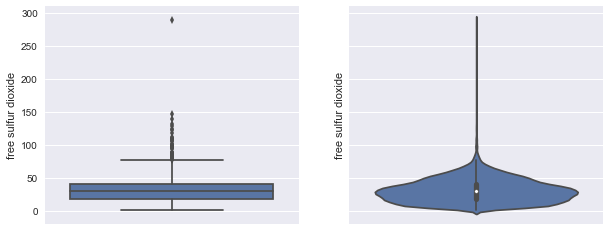

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4));
#ax1 = fig.add_subplot(121);
#ax2 = fig.add_subplot(122,sharey = ax1);
#ax = sn.swarmplot(data=df_unicard[['SALDO_DISPONIBLE','CUPO_NACIONAL']]);
#sn.boxplot(data = df['free sulfur dioxide'], orient = 'v');
sn.violinplot(df['free sulfur dioxide'],ax = ax2, orient = 'v');
sn.boxplot(df['free sulfur dioxide'], orient='v', ax = ax1);

<p style="text-align:center;font-size:95%"><b>Figura 2.1:</b> Graficos de violín y boxplot para la variable 'free sulfur dioxide'</p>

In [9]:
df[np.abs(df['free sulfur dioxide']-df['free sulfur dioxide'].mean())>=250]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,tipo
6344,6.1,0.26,0.25,2.9,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,1


Parece haber solo un outlier que aleja notablemente del grueso de la distribución para la variable *free sulfur dioxide*, la calidad de dicho vino es baja y su tipo es 'blanco'. Este outlier puede interferir en el poder predictivo de un modelo si este se basa en alguna métrica de distancia, puede ser tratado y reemplazado el valor de dicho registro por el de la mediana de la distribución de la variable en cuestión, o puede ser dejado intacto con el argumento de que justamente este tipo de irragularidades pueden enseñarle a una máquina a detectar que valores atípicos generan un vino de mala calidad. Por ahora se dejará asi y se experimentará luego para determinar si hay cambios significativos en el poder de generalización del modelo.

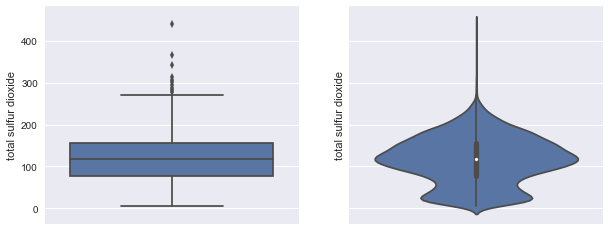

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4));
#ax1 = fig.add_subplot(121);
#ax2 = fig.add_subplot(122,sharey = ax1);
#ax = sn.swarmplot(data=df_unicard[['SALDO_DISPONIBLE','CUPO_NACIONAL']]);
#sn.boxplot(data = df['free sulfur dioxide'], orient = 'v');
sn.violinplot(df['total sulfur dioxide'],ax = ax2, orient = 'v');
sn.boxplot(df['total sulfur dioxide'], orient='v', ax = ax1);

Un comportamiento similar se observa para la variable 'total sulfur dioxide', relacionada aparentemente con 'free sulfur dioxide', sin embargo, la distribución no se ve estropeada por tan solo un valor extremadamente alto, sino que hay una serie de registros que presentan valores altos de esta variable, por lo que el máximo en este caso no se considerará como un outlier que deba ser cuestionado.

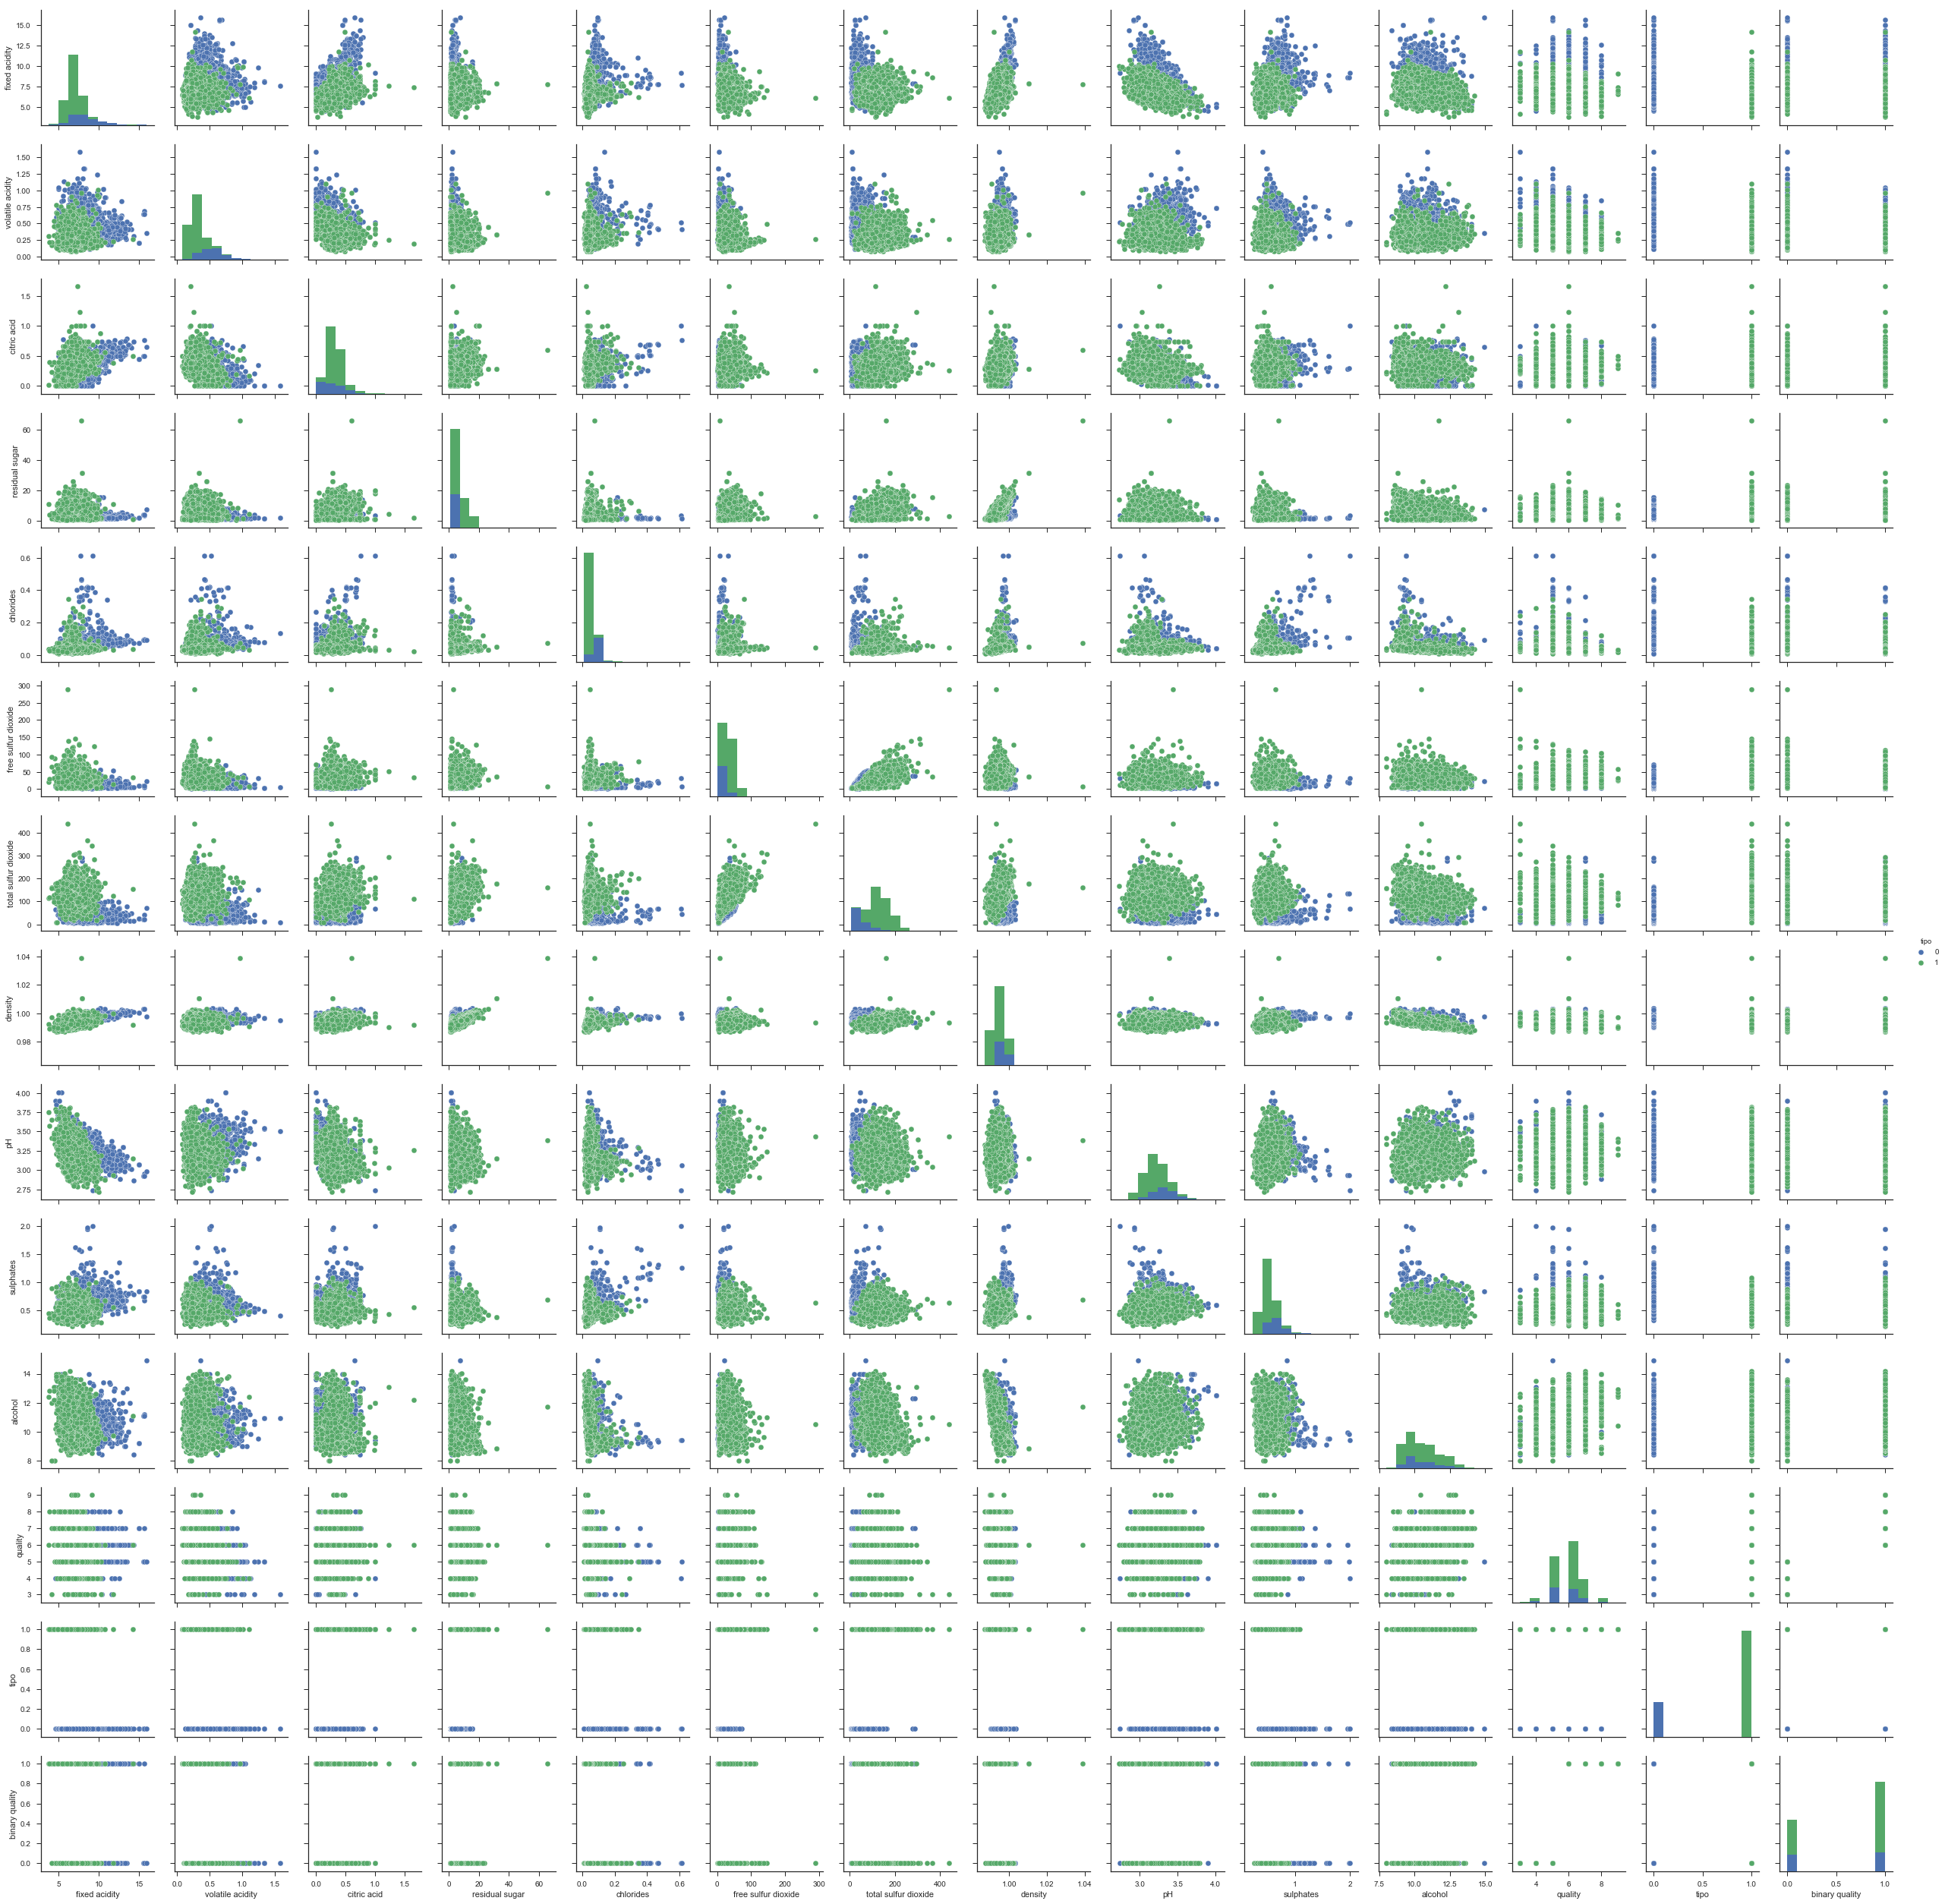

In [11]:
sn.set(style="ticks")

sn.pairplot(df_bin, hue="tipo");

La anterior matriz de gráficos de dispersión muestra algunas relaciones interesantes que hacen dudar sobre replicación de información, como por ejemplo la relación entre 'total sulfur dioxide' y 'free sulfur dioxide', en este caso puede ser que en efecto la información de una de estas variables esté de forma implícita en la otra.<br>
* Se observan relaciones interesantes como la de las variables *density* y *residual sugar*.
* Parece ser que graficar la variable 'chlorides' con *fixed acidity*, *volatile acidity* o *citric acid* permite obtener una división relativamente clara de el tipo de vino, lo que probablemente sea consecuencia de las diferencias en la composición y propiedades químicas propias de cada tipo de vino.

Estudiemos las correlaciones para verficar si hay información replicada:

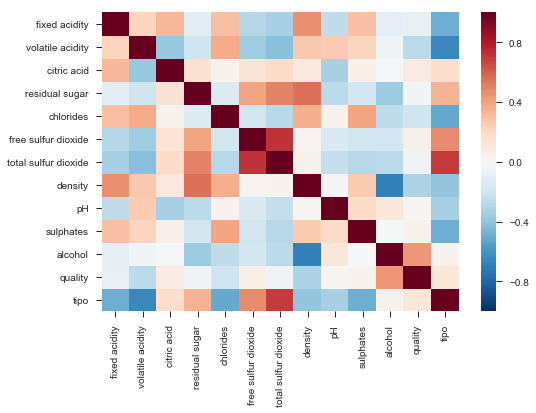

In [12]:
#pd.corr(df['free sulfur dioxide'], df['total sulfur dioxide'])
sn.heatmap(df.corr());

Destaca la correlación que hay entre *free sulfur dioxide* y *total sulfur dioxide*, con el fin de tener claridad sobre una posible transformación subyacente que implica replicación de información, realizaremos una regresión lineal entre ambos atributos, con un nivel de confianza de 95% para rechazar la hipótesis de que *free sulfur dioxide* no condiciona los valores de *total sulfur dioxide*.

In [13]:
x_sm = df_bin['free sulfur dioxide']
#x_sm = sm.add_constant(x_sm)
#x_sm.insert(x_sm.shape[1], 'intercept', np.ones(x_sm.shape[0]))
y_sm = df_bin['total sulfur dioxide']

model = sm.OLS(y_sm,x_sm)
results = model.fit()
print(results.summary())

#linreg = lm.LinearRegression(fit_intercept = False)
#linreg.fit(df_bin['free sulfur dioxide'], df_bin['total sulfur dioxide'])

                             OLS Regression Results                             
Dep. Variable:     total sulfur dioxide   R-squared:                       0.876
Model:                              OLS   Adj. R-squared:                  0.876
Method:                   Least Squares   F-statistic:                 4.580e+04
Date:                  Sat, 23 Dec 2017   Prob (F-statistic):               0.00
Time:                          22:26:44   Log-Likelihood:                -34008.
No. Observations:                  6497   AIC:                         6.802e+04
Df Residuals:                      6496   BIC:                         6.802e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
free sulfur di

El p-valor que entrega el modelo para el coeficiente de la regresión es menor a 0.05, por lo que vamos a aceptar la hipótesis de que existe una transformación lineal que explica 'total sulfur dioxide' a través de 'free sulfur dioxide' con un 95% de confianza, eliminaremos entonces del modelo el segundo atributo.

In [90]:
df_bin.drop(['free sulfur dioxide'], axis = 1, inplace = True);

Como ya sabemos que el atributo *quality* particiona perfectamente el problema, eliminaremos esta variable para que el árbol no le otorgue demasiada importancia a este atributo con respecto a los demás, en lugar de esto, trataremos el problema como si fuese un problema de clasificación binaria, donde fijaremos un umbral de calidad de 5 o más para un vino de buena calidad y su complemento para uno de mala calidad, generamos una etiqueta artifical y entrenamos a distintos clasificadores para observar su desempeño:

In [91]:
df_bin.drop(['quality'], axis = 1, inplace = True)
x_train, x_test, y_train, y_test = train_test_split(
    df_bin.loc[:, df_bin.columns != 'binary quality'],
    df_bin.loc[:, df_bin.columns == 'binary quality'],
    test_size = 0.25,
    shuffle=True,
    random_state = 42)

<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> II) Árbol de Clasificación Binario</h3></i>

Nuestra primera aproximación para modelar el problema será mediante la utilización de un árbol de clasificación multinivel, la matriz de entrenamiento y test es de la siguiente forma:

In [93]:
#c) CT multinivel, evaluación de metrica F1
print("Nº Atributos: %d" %x_train.shape[1])
print("Nº Obs. de entrenamiento: %d" %x_train.shape[0])
print("Nº Obs. de test: %d" %x_test.shape[0])

Nº Atributos: 11
Nº Obs. de entrenamiento: 4872
Nº Obs. de test: 1625


In [106]:
#Primero veamos a que resultado llega restringiendo la profundidad a 5
mean_tree_f1error, tree_clf = cv_error(x_train, y_train, method = 'TreeClassifier', k = 10, max_depth = 5)

Para obtener un modelo, debemos ajustar sus hiperparámetros, en el caso de nuestro árbol de clasificación debemos encontrar la profundidad máxima permitida al árbol que maximice la métrica que estamos utilizando para medir el rendimiento del mismo, en nuestro caso el *F1 Score*. Utilizando *10-Fold Cross-Validation* obtenemos el siguiente gráfico:

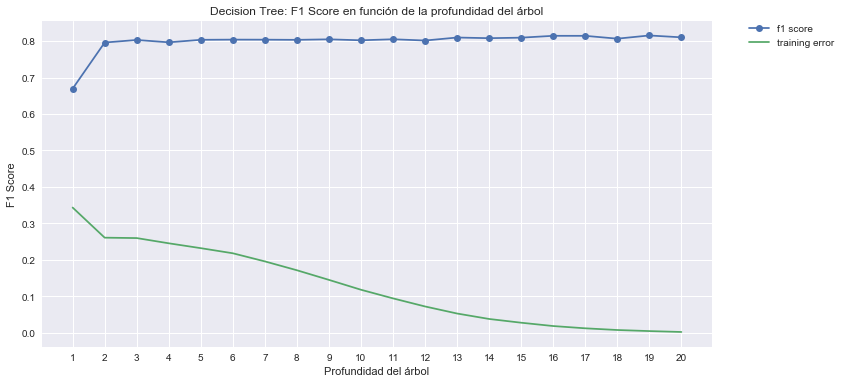

In [302]:
best_tree,best_tree_score = plot_cv_error(x_train, y_train, meth = 'TreeClassifier',max_depth = 20)

Observamos un claro sobreajuste después de fijar una profundidad máxima de catorce o quince niveles, la profundidad máxima del árbol que obtuvo la mejor métrica de *F1 Score* es el siguiente:

In [229]:
print("Best Validation tree depth: %d" % best_tree.max_depth)
print("Best Validation F1 Score: %.2f" % best_score)

Best Validation tree depth: 14
Best Validation F1 Score: 0.82


El correspondiente error y *F1 score* de pruebas es:

In [231]:
print("Test error for best tree:%.2f" %best_tree.score(x_test,y_test))
print("Test F1 score for best tree:%.2f" %f1_score(y_test,best_tree.predict(x_test)))

Test error for best tree:0.75
Test F1 score for best tree:0.80


El ranking de importancia de los atributos creado por el clasificador es el siguiente:

In [244]:
#len(x_train.columns)
#len(best_tree.feature_importances_)

pd.DataFrame(best_tree.feature_importances_.round(3), index=x_train.columns, columns = ['Importance Score']).sort_values(by = 'Importance Score', ascending = False)

,Importance Score
alcohol,0.230
volatile acidity,0.159
residual sugar,0.090
citric acid,0.081
sulphates,0.080
density,0.078
fixed acidity,0.075
pH,0.073
chlorides,0.070
total sulfur dioxide,0.063


Cabe destacar que no hay un sesgo en la calidad de los vinos, es decir, los vinos de la muestra que son de un tipo, no presentan una calidad superior en promedio a los del otro tipo.

<i><h2 style="font-family:serif;font-size:160%; text-align:center;color:#004d80">El azucar y el nivel de alcohol juegan un papel importante a la hora de determinar la calidad de un vino, al igual que la acidez volátil del mismo.</h2></i>



<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> III) Bosque Aleatorio</h3></i>

Ahora procederemos a abordar el problema mediante el método de ensamblado de bosque aleatorio.

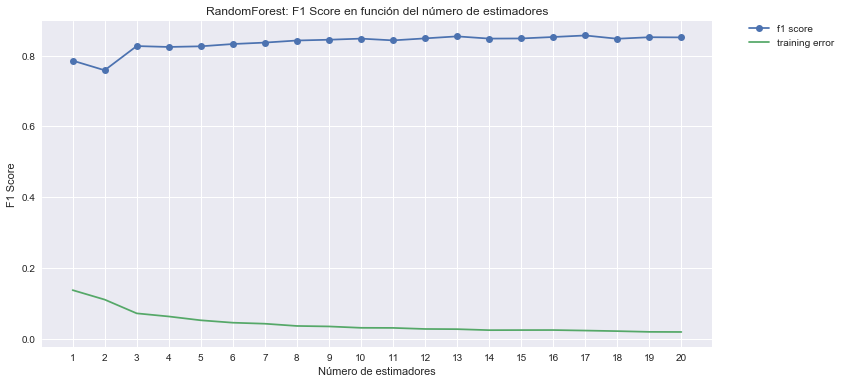

In [290]:
best_forest,best_forest_score = plot_cv_error(x_train, y_train, meth = 'RandomForest',
                                       max_depth = best_tree.max_depth, max_estimators = 20)

Los parámetros del mejor bosque aleatorio, según nuestra métrica de *F1 Score* son:

In [268]:
print("Best Validation Forest tree depth: %d" % best_forest.max_depth)
print("Best Validation Forest number of estimators: %d" % best_forest.n_estimators)
print("Best Validation F1 Score: %.2f" % best_forest_score)

Best Validation Forest tree depth: 14
Best Validation Forest number of estimators: 17
Best Validation F1 Score: 0.86


El correspondiente error y métrica *F1 Score* para el conjunto de pruebas es:

In [271]:
print("Test error for best forest:%.2f" %best_forest.score(x_test,y_test))
print("Test F1 score for best forest:%.2f" %f1_score(y_test,best_forest.predict(x_test)))

Test error for best forest:0.80
Test F1 score for best forest:0.85


Obtuvimos una leve mejora de 0.05 en la métrica utilizando el método de RandomForest en comparación con el árbol de clasificación binario.

In [272]:
pd.DataFrame(best_forest.feature_importances_.round(3), index=x_train.columns,
             columns = ['Importance Score']).sort_values(by = 'Importance Score', ascending = False)

,Importance Score
alcohol,0.155
volatile acidity,0.126
density,0.125
total sulfur dioxide,0.097
residual sugar,0.088
chlorides,0.088
sulphates,0.087
citric acid,0.084
pH,0.077
fixed acidity,0.071


Nuestro método de ensamblado encuentra que los atributos más relevantes son el alcohol, la acidez volátil y la densidad, en este caso el azucar residual no parece jugar un papel especialmente importante a la hora de determinar la calidad de un vino.

<i><h2 style="font-family:serif;font-size:160%; text-align:center;color:#004d80"> El bosque aleatorio deduce que los atributos más relevantes en la calidad de un vino son el nivel de alcohol que posee, su acidez volátil y la densidad.</h2></i>



<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> IV) AdaBoost</h3></i>

En esta sección trabajaremos utilizando el método de ensamblado Adaboost.

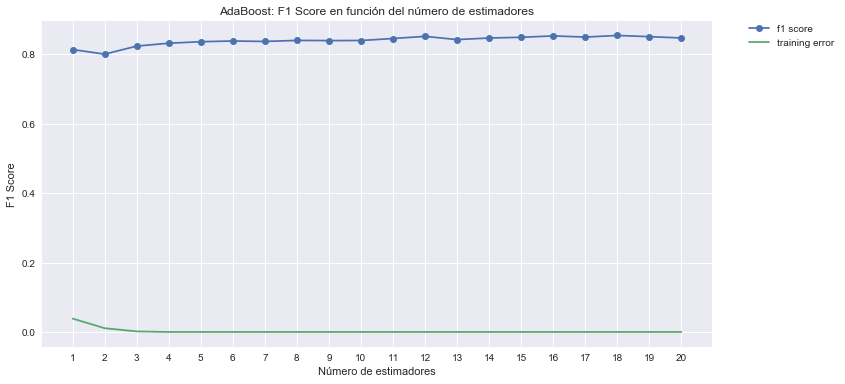

In [281]:
best_ada,best_ada_score = plot_cv_error(x_train, y_train, meth = 'AdaBoost',
                                       max_depth = best_tree.max_depth, max_estimators = 20)

AdaBoost al parecer se sobreajusta considerablemente rápido en comparación con el bosque aleatorio, vemos que para tan solo un número de estimadores de 3 ya se reduce el error de entrenamiento a 0.0.

Los parámetros del mejor AdaBoost, según nuestra métrica de *F1 Score* son:

In [283]:
print("Best Validation AdaBoost number of estimators: %d" % best_ada.n_estimators)
print("Best Validation F1 Score: %.2f" % best_ada_score)

Best Validation AdaBoost number of estimators: 18
Best Validation F1 Score: 0.85


El correspondiente error y métrica *F1 Score* para el conjunto de pruebas es:

In [285]:
print("Test error for best AdaBoost:%.2f" %best_ada.score(x_test,y_test))
print("Test F1 score for best AdaBoost:%.2f" %f1_score(y_test,best_ada.predict(x_test)))

Test error for best AdaBoost:0.79
Test F1 score for best AdaBoost:0.84


<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> V) K Nearest Neighbors Classifier</h3></i>

Finalmente, utilizaremos el clasficador K-Nearest Neightbors para poder contrastar con un método de aprendizaje no supervisado.

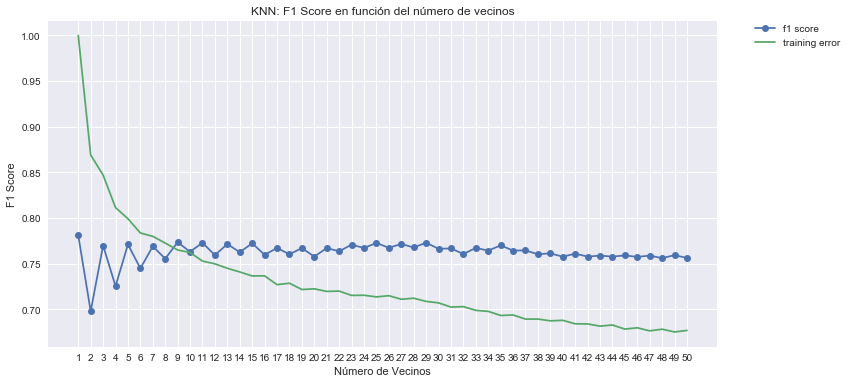

In [297]:
best_knn,best_knn_score = plot_cv_error(x_train, y_train, meth = 'KNN', max_neighbors = 50)

Curiosamente los máximos locales en la curva de *F1 Score* se parecen producir siempre para un número impar de vecinos. El error de entrenamiento parece bajar monótonamente a mayor número de vecinos, probablemente sea, debido a la naturaleza del algoritmo, sobreajuste al conjunto de entrenamiento. En la gráfica el *peak* de la métrica se obtiene para el primer valor probado, para tan solo un vecino.

In [299]:
print("Best Validation KNN number of neighbors: %d" % best_knn.n_neighbors)
print("Best Validation F1 Score: %.2f" % best_knn_score)

Best Validation KNN number of neighbors: 1
Best Validation F1 Score: 0.78


No hemos logrado superar la métrica para el conjunto de validación que teníamos hasta el momento. El correspondiente error y métrica *F1 Score* para el conjunto de pruebas es:

In [300]:
print("Test error for best KNN:%.2f" %best_knn.score(x_test,y_test))
print("Test F1 score for best KNN:%.2f" %f1_score(y_test,best_knn.predict(x_test)))

Test error for best KNN:0.72
Test F1 score for best KNN:0.77


Tampoco hemos logrado superar la métrica para el conjunto de pruebas.

In [310]:
pd.DataFrame([f1_score(y_test,best_tree.predict(x_test)).round(2), f1_score(y_test,best_forest.predict(x_test)).round(2), f1_score(y_test,best_ada.predict(x_test)).round(2), f1_score(y_test,best_knn.predict(x_test)).round(2)],
             index = ['Decision Tree', 'Random Forest', 'AdaBoost', 'KNN'],
             columns = ['Test F1 Score']).sort_values(by = 'Test F1 Score', ascending = False)


,Test F1 Score
Random Forest,0.84
AdaBoost,0.84
Decision Tree,0.79
KNN,0.77


El mejor *F1 Score* para el conjunto de pruebas lo obtienen los métodos de Bosque Aleatorio y AdaBoost.

<i><h2 style="font-family:serif;font-size:160%; text-align:center;color:#004d80"> El Bosque Aleatorio y AdaBoost obtienen los mejores resultados cuando se requiere predecir la calidad de un vino, obteniendo ambos una métrica *F1 Score* igual a 0.84</h2></i>

